<a id='introduction'></a> 
# INTRODUCTION

In [7]:
import urllib.request
import numpy as np
import pandas
import datetime
import os
import cdflib
import cdflib.epochs as epoch
from pathlib import Path
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import tdscdf as loader # also contains other functions from this notebook


<a id='descriptions'></a> 
## Brief descriptions

### 1. RPW/TDS block diagram

<img src=./Pictures/solo_tds_block.png  width=90%>    
<br>

### 2. Spacecraft Reference Frame (SRF)

<br>
<img src=./Pictures/SRF.png  width=70%>    
<br>




<a id='data'></a> 
## Data functions  

In [8]:
# Convering to SRF
def convert_to_SRF(data, index=0):
    """ 
        Convert TDS SWF from the antenna to the spacecraft 
        reference frame (SRF).
        Using the effective antenna directions
        two components of the E-field in the Y-Z SRF plane
        are calculated for the given TDS configuration.
        data(ncomp, nsamples) - input array 2-D vectors of the electric field expressed in the
                    ANT coordinate system in V/m
        index - a snapshot number to be transformed, the first is default
        E(2,nsamples) - 2D E-field E[0, *] = Ey, E[1, *] = Ez
    """
    nsamp = data['SAMPS_PER_CH'][index]
    tds_mode = data['TDS_CONFIG_LABEL'][index]
    if 'SE1' in tds_mode:
        # Pachenko's antenna angle
        pacang = np.deg2rad(125)
        V1 = [0, 1]
        # Pachenko monopole antennas
        V2 = [np.sin(pacang), np.cos(pacang)]
        V3 = [-np.sin(pacang), np.cos(pacang)]
        # SE1 TDS mode
        M = np.array([V1, V2])  # [CH1, CH2]
    else:
        pacang = np.deg2rad(158.1)
        ant21 = [np.sin(pacang), np.cos(pacang)]  # E - field in the same sense.
        pacang = np.deg2rad(-158.2)
        ant13 = [-np.sin(pacang), -np.cos(pacang)]  # ant31 then - 1. to ant13
        M = np.array([ant13, ant21])  # [CH1, CH2]

    ww = data['WAVEFORM_DATA'][index, :, 0:nsamp]
    # projection: E = MAT(ANT->SRF) * V; where MAT(2,2) and V is observed field
    M = np.linalg.inv(M)
    E = np.dot(M, ww[0:2, :]) * 1e3  # transformation into SRF (Y-Z) in (mV/m)
    return E

def get_monopole_ant(data, index=0):
    """ 
        Get TDS SWF from the dipole antenna configuration into the monopole configuration
        waveform_data_voltage(ncomp, nsamples) - input array 3-D vectors of the electric field 
        expressed in the ANT coordinate system in Volts
        index - a snapshot number to be transformed, the first is default
        V(3,nsamples) - V[0, *] = V1, V[1, *] = V2, V[2, *] = V3
        If TDS is not in SE1 or XLD1 configuration then return empty array
    """
    nsamp = data['SAMPS_PER_CH'][index]
    tds_mode = data['TDS_CONFIG_LABEL'][index]
    if 'SE1' in tds_mode:
        return data['WAVEFORM_DATA_VOLTAGE'][index, 0:3, 0:nsamp]
    elif 'XLD1' in tds_mode:
        ww = np.full((3, nsamp), -1e31, 'single')
        ww[0, :] = data['WAVEFORM_DATA_VOLTAGE'][index, 2, 0:nsamp] - data['WAVEFORM_DATA_VOLTAGE'][index, 1, 0:nsamp]
        ww[1, :] = data['WAVEFORM_DATA_VOLTAGE'][index, 2, 0:nsamp]
        ww[2, :] = ww[0, :] - data['WAVEFORM_DATA_VOLTAGE'][index, 0, 0:nsamp]
        return ww
    else:
        print(f'Unsupported TDS_CONFIG:{tds_mode}! No extraction made!')
        return np.full((3, nsamp), -1e31, 'single')
    


In [9]:
# Waveform plot
def plot_waveform(ww, t0, sr):
    """
        Plotting the TDS-TSWF waveform snapshots
    """
    nsamp = int(ww.shape[1])
    timestr = t0.strftime('%Y/%m/%d, %H:%M:%S.%f')
    tt = np.arange(0, nsamp/sr, 1/sr)*1e3
    
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8, 6), dpi=80)
    ax1.plot(tt,ww[0, :])
    ax1.set(ylabel='$EY_{SRF}$ (mV/m)')
    
    ax2.plot(tt,ww[1, :])
    ax2.set(ylabel='$EZ_{SRF}$ (mV/m)')
    plt.xlabel('Time since trigger (ms)')
    plt.suptitle(('TDS-TSWF waveforms in SRF: %s SWF#%d' % (timestr, rec)))
    plt.xlim(0, nsamp/sr*1e3)
    plt.show()

    
# Spectrum
def plot_spectrum(ww, t0, sr):
    """
        Plotting the TDS-TSWF spectra computed from Ey and Ez SRF 
    """
    figure(figsize=(8, 6), dpi=80)
    nsamp = int(ww.size/2)
    tt = np.arange(0, nsamp/sr, 1/sr)
    fourier_transform = np.fft.rfft(ww)
    abs_fourier_transform = np.abs(fourier_transform)
    power_spectrum = np.square(abs_fourier_transform)
    frequency = np.linspace(0, sr / 2, len(power_spectrum[0,:]))
    xmin = (np.abs(frequency - 200)).argmin()
    if sr>300000:
        fmax = 200000
    else:
        fmax = 100000
    xmax = (np.abs(frequency - fmax)).argmin()
    
    plt.plot(frequency[xmin:xmax]*1e-3, power_spectrum[0, xmin:xmax])
    plt.plot(frequency[xmin:xmax]*1e-3, power_spectrum[1, xmin:xmax])
    plt.legend(['$EY_{SRF}$','$EZ_{SRF}$'])
    
    plt.yscale("log")
    plt.xlim(2, fmax*1e-3)
    plt.xlabel('Frequency (kHz)')
    plt.ylabel('Power spectral density')
    timestr = t0
    plt.title(('SolO TDS TSWF spectrum  %s SWF#%d' % (timestr, rec)))
    

# Hodogram
def plot_hodogram(ww, t0, size=200, samp=-1):
    """
        Plotting a hodogram from Ey-Ez components 
    """
    figure(figsize=(8, 6), dpi=80)
    nsamp = int(ww.size/2)
    if samp == -1:
        amp = np.abs(ww[0, :]) + np.abs(ww[1, :])
        samp = np.argmax(amp)
        if samp<size/2:
            samp = 251
        elif samp>nsamp-(size/2):
            samp = nsamp-251

    if samp < size / 2:
        samp = size + 1
    elif samp > nsamp - (size / 2):
        samp = nsamp - size - 1

    y = ww[0, int(samp-size):int(samp+size/2)]
    z = ww[1, int(samp-size):int(samp+size/2)]
    
    plt.plot(y,z)
    m = ww.max()*1.1
    plt.gca().set_aspect('equal')
    plt.xlim(-m,m)
    plt.ylim(-m,m)
    plt.xlabel('$EY_{SRF}$ (mV/m)')
    plt.ylabel('$EZ_{SRF}$ (mV/m)')
    timestr = t0
    plt.title(('SolO TDS TSWF hodogram %s SWF#%d' % (timestr, rec)))
    plt.show()
    

# Examples

## Download, load cdf file and convert waveforms into SRF

In [10]:
"""
    Downloading TDS-SURV-TSWF cdf file for a given date.
    !! The file might have a size of several hundreds of MB
"""
date = (2023,3,21)
tswf = loader.load_data(date, product='surv-tswf') # Downloads from SOAR archive

No local file(s) found for 2023/03
Downloading...
Download complete


## Plot waveform

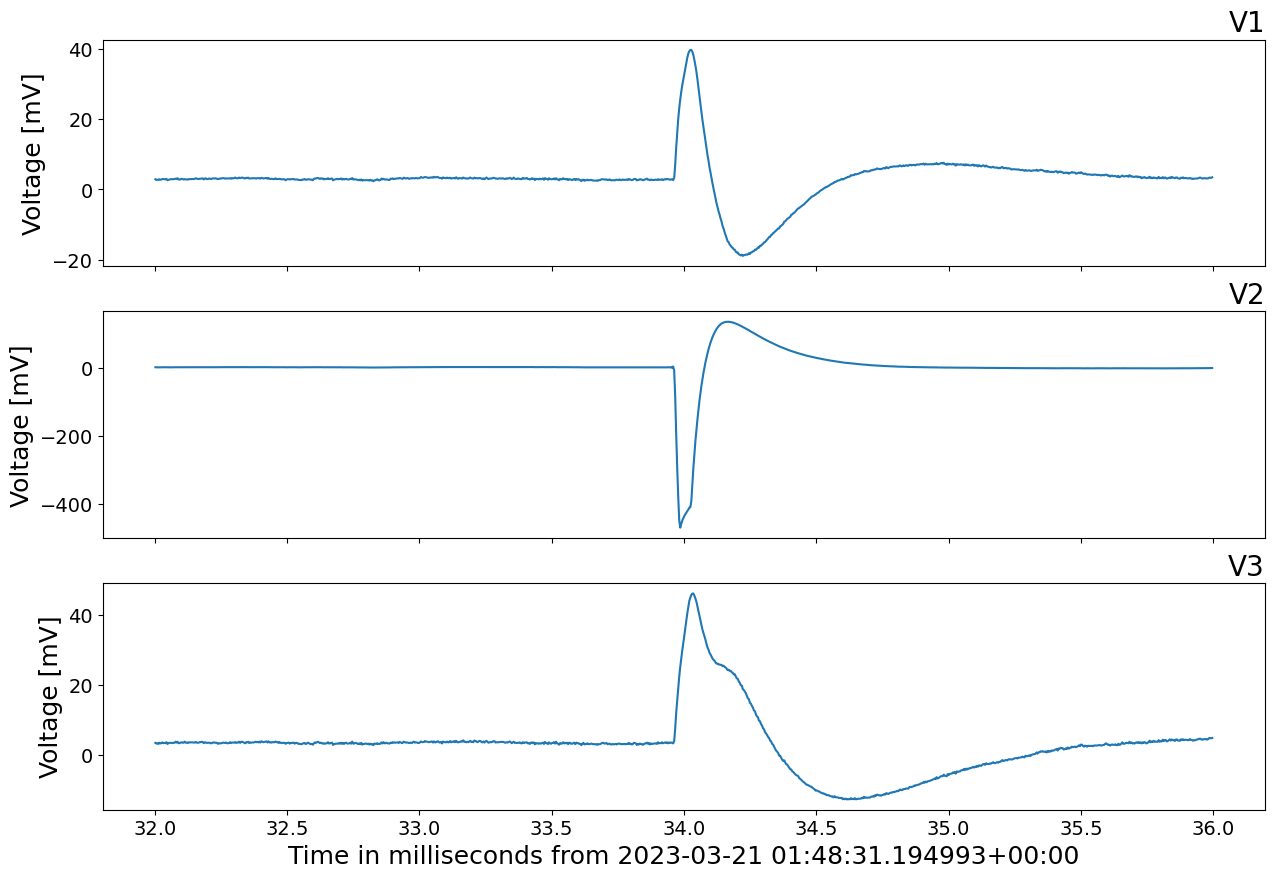

In [11]:
# Waveform plot
"""
    Plot TDS-TSWF snapshot
    Select snaphost #100, do conversion ANT->SRF coordinates, !! only Y, Z components !!
    Plot waveform
"""
# find TSWF records with DUST label, i.e. DOWNLINK_INFO[1] == 2
ind = np.asarray(tswf['DOWNLINK_REASON'][:] == 2).nonzero()[0]
rec = ind[2]
t0 = cdflib.epochs.CDFepoch.to_datetime(tswf['Epoch'][rec])[0]
t0 = datetime.datetime.fromtimestamp(t0.astype(int) * 1e-9, datetime.UTC)
nsamp = tswf['SAMPS_PER_CH'][rec]
sr = tswf['SAMPLING_RATE'][rec]
ww = get_monopole_ant(tswf, index=rec) * 1e3 # V -> mV
time = np.array(range(0, nsamp) / sr * 1e3) # time vector in milliseconds
idx = np.asarray((time > 32) & (time < 36)).nonzero()[0]
fig, axs = plt.subplots(3, 1, figsize=(15, 10), sharex=True, facecolor='white')
for i in [0, 1, 2]:
    ax = axs[i]
    ax.plot(time[idx], ww[i, idx])
    ax.set_ylabel('Voltage [mV]', fontsize=18)
    if tswf['CHANNEL_OVERFLOW'][rec,i]==1:
        ax.set_title(f'V{i+1} saturated', color='red', loc='right', fontsize=20)
    else:
        ax.set_title(f'V{i+1}', loc='right', fontsize=20)
    ax.tick_params(labelsize=14)
axs[-1].set_xlabel(f'Time in milliseconds from {t0}', fontsize=18)

plt.show()

loading solo_L2_rpw-tds-surv-tswf-e-cdag_20211101_V05.cdf
loading solo_L2_rpw-tds-surv-mamp-cdag_20211101_V04.cdf
2021-11-01T07:22:39.753693184 2021-11-01T07:22:39.816190976


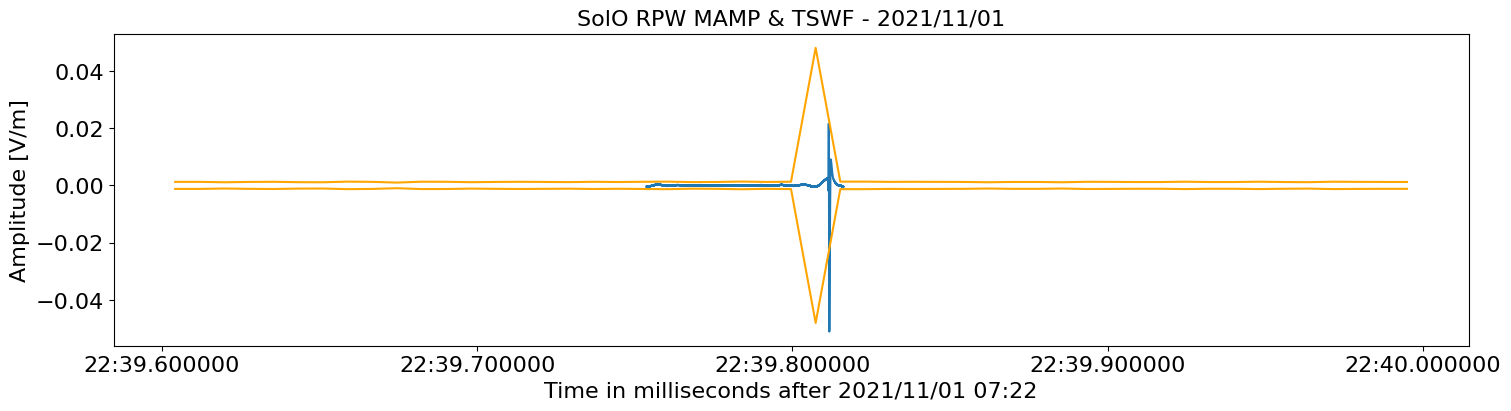

In [11]:
date = (2021, 11, 1, 7, 22, 39, 600)
tlen = 0.4
rswf = loader.load_data(date, tlen=tlen, product='surv-tswf')
mamp = loader.load_data(date, tlen=tlen, product='surv-mamp')

snap_nr = 0
times = cdflib.cdfepoch.to_datetime(np.int64(rswf['Epoch'][snap_nr] + np.arange(
    0, rswf['SAMPS_PER_CH'][snap_nr], dtype='int64') / rswf['SAMPLING_RATE'][snap_nr] * 1e9))
ep = cdflib.cdfepoch.to_datetime(mamp['Epoch'])

mamp['WAVEFORM_DATA'][np.asarray(mamp['WAVEFORM_DATA'] < 0).nonzero()] = float('nan')

fig, ax = plt.subplots(figsize=(15, 4), layout='constrained', sharex=True)
t0 = ep[0]
t0 = datetime.datetime.fromtimestamp(t0.astype(int) * 1e-9, datetime.UTC)
sdate = t0.strftime('%Y/%m/%d')
print(times[0], times[-1])
ax.plot(times, rswf['WAVEFORM_DATA'][snap_nr, 1, :])
ax.plot(ep, mamp['WAVEFORM_DATA'][:,1], c='orange')
ax.plot(ep, -1.*mamp['WAVEFORM_DATA'][:,1], c='orange')
ax.tick_params(axis='y', labelsize=14)
ax.set_title(f"SolO RPW MAMP & TSWF - {sdate}", fontsize=16)
ax.set_ylabel('Amplitude [V/m]', fontsize=16)

sdate = t0.strftime('%Y/%m/%d %H:%M')
ax.set_xlabel(f'Time in milliseconds after {sdate}', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show() 

loading solo_L2_rpw-tds-surv-tswf-e-cdag_20220409_V03.cdf
loading solo_L2_rpw-tds-surv-rswf-e-cdag_20220409_V03.cdf
loading solo_L2_rpw-tds-surv-stat-cdag_20220409_V03.cdf


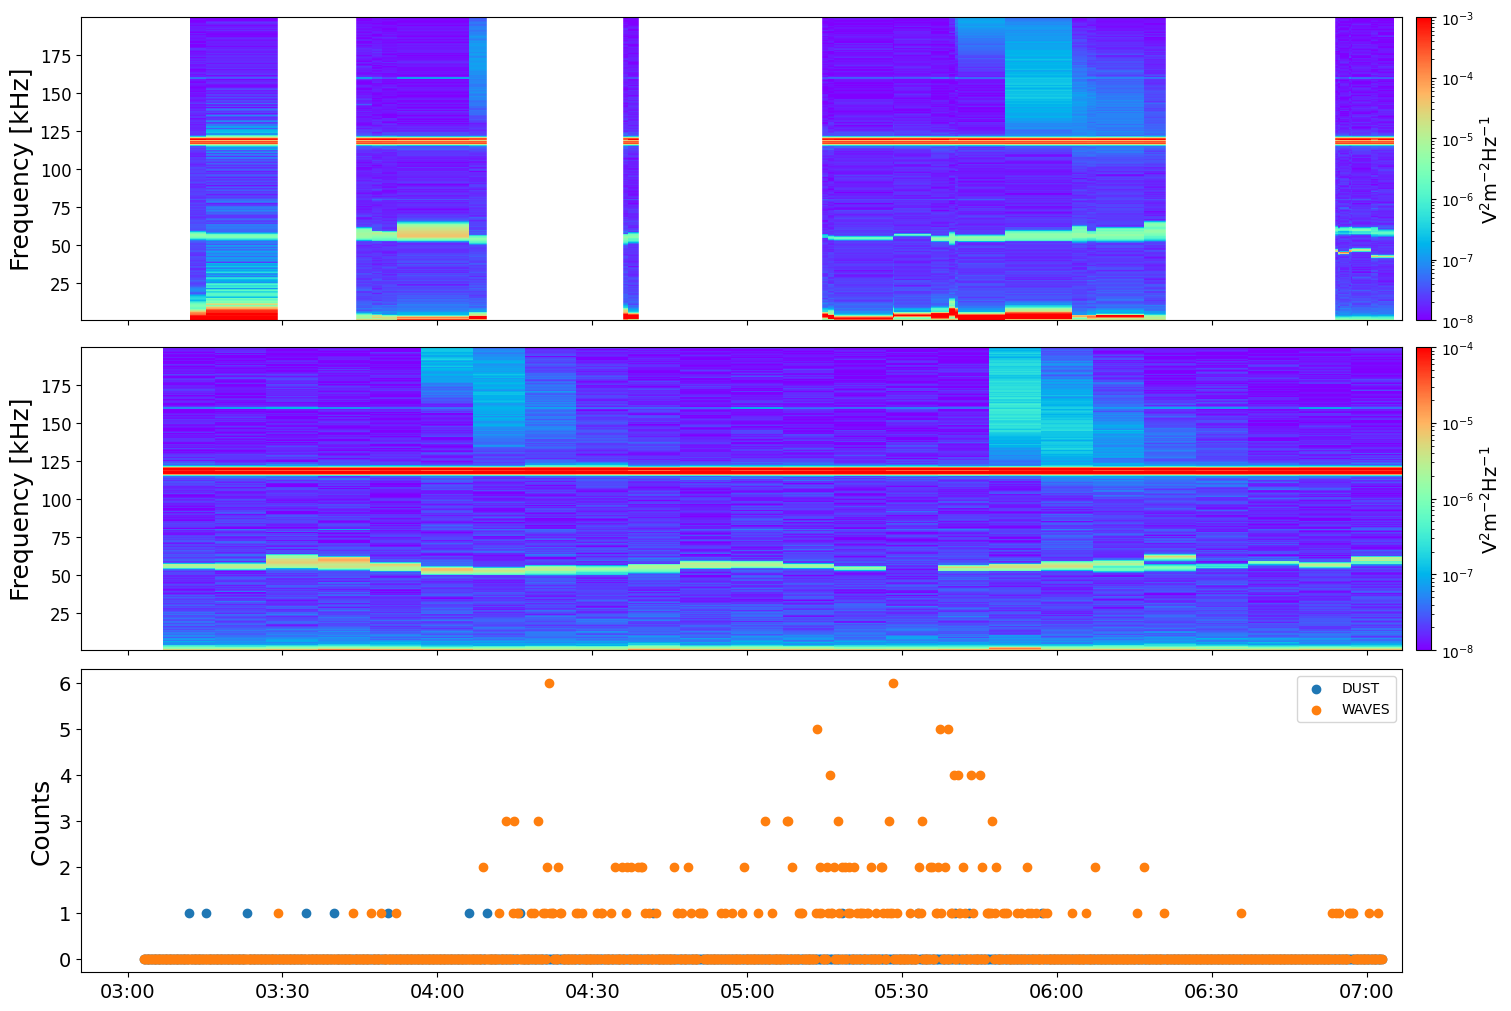

In [12]:
import numpy as np
import cdflib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime
import tdscdf
import tdsplot
import matplotlib.dates as mdates


time = (2022, 4, 9, 3, 3) # START TIME
tlen = 4 * 3600 # Time interval

tswf = loader.load_data(time, tlen=tlen, product='surv-tswf')
rswf = loader.load_data(time, tlen=tlen, product='surv-rswf')
stat = loader.load_data(time, tlen=tlen, product='surv-stat')

fig, ax = plt.subplots(3, 1, figsize=(15, 10), layout='constrained', sharex=True)
ep = cdflib.cdfepoch.to_datetime(stat['Epoch'])    
sdate = datetime.datetime.fromtimestamp(ep[0].astype(int) * 1e-9, datetime.UTC).strftime('%Y/%m/%d')

[Pwx, Freq, Epoch] = tdsplot.tds_calculate_swf_spectrogram(tswf, channel=0, frqmin=1e3, frqmax=2e5)
[Pwy, Freq, Epoch] = tdsplot.tds_calculate_swf_spectrogram(tswf, channel=1, frqmin=1e3, frqmax=2e5)
Pwsum = np.sqrt(Pwx**2 + Pwy**2)
Freq /= 1e3
ax[0] = tdsplot.tds_plot_swf_spectrogram(Epoch, Freq, Pwsum, ax=ax[0], vmin=1e-8)
ax[0].set_ylabel('Frequency [kHz]', fontsize=18)

[Pwx, Freq, Epoch] = tdsplot.tds_calculate_swf_spectrogram(rswf, channel=0, frqmin=1e3, frqmax=2e5)
[Pwy, Freq, Epoch] = tdsplot.tds_calculate_swf_spectrogram(rswf, channel=1, frqmin=1e3, frqmax=2e5)
Pwsum = np.sqrt(Pwx**2 + Pwy**2)
Freq /= 1e3
ax[1] = tdsplot.tds_plot_swf_spectrogram(Epoch, Freq, Pwsum, ax=ax[1], vmin=1e-8)
ax[1].set_ylabel('Frequency [kHz]', fontsize=18)

ax[2] = plt.scatter(ep, stat['DU_NR_IMPACT'], label='DUST')
ax[2] = plt.scatter(ep, stat['WA_NR_EVENTS'], label='WAVES')
ax[2] = plt.ylabel('Counts', fontsize=18)
ax[2] = plt.legend()

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.show()

## TDS SURV HIST1D - 1D Histograms based on Statistics

* Peak wave amp. (V/m)
* Peak snapshot amp. (V/m)
* RMS wave amp. (V/m) 
* RMS snapshot amp. (V/m)
* Dust amp. (V/m) 
* Wave central freq. (Hz)
* Wave parameter block
* Wave-packet bandwidth (Hz)
* Dust ramp (Samles/s)
* Max. amp. in CH1 (V/m)
* Max. amp. in CH2 (V/m)
* Max. amp. in CH3 (V/m)
* Max. amp. in CH4 (V/m)
* Quality factor of waves'

## TDS SURV HIST2D - 2D Histograms based on Statistics

* Dust Amp. vs. Rising edge
* Wave peak amp. vs. Bandwidth
* Wave RMS vs. Bandwidth
* Wave peak amp. vs. RMS
* Snapshot peak amp. vs RMS 
* Wave peak amp. vs. Central freq.
* Wave RMS vs. Central freq.
* Wave central freq. vs. Bandwidth

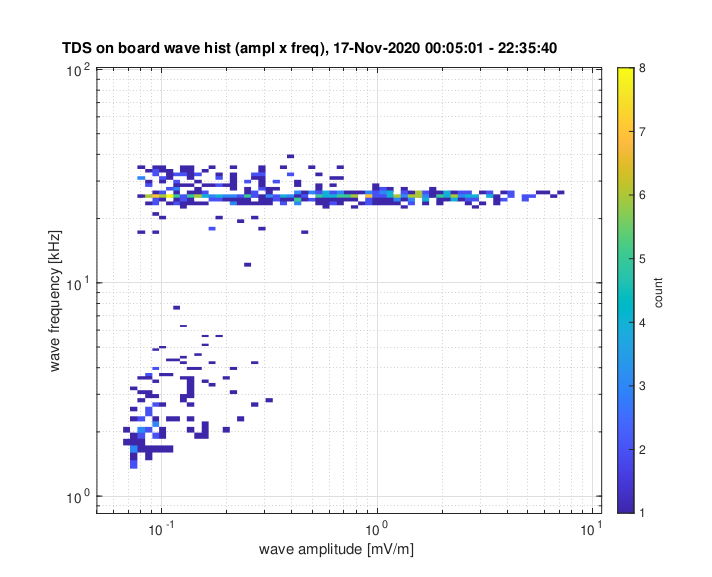

# Dust impact with the magnetic signature
The below example shows the TDS TSWF snapshot with the dust signature in both electric (3 channels) and magnetic (1 component) fields.

No local file(s) found for 2021/09
Downloading...
File already exists, skipping download


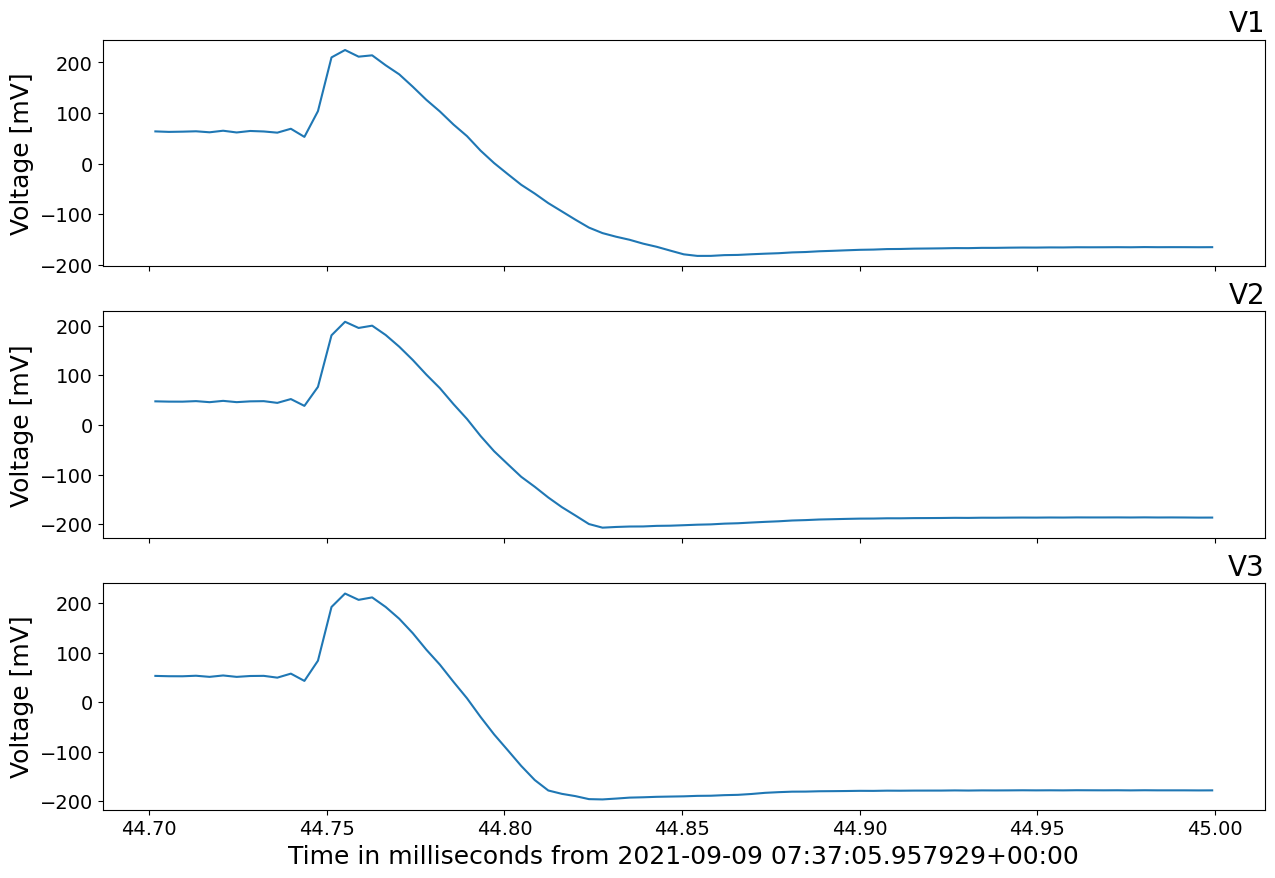

In [6]:
import numpy as np
import cdflib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime
import tdscdf
import tdsplot
import matplotlib.dates as mdates
import solocdf


tswf = tdscdf.load_data((2021,9,9), product='surv-tswf')

rec = 91
t0 = cdflib.epochs.CDFepoch.to_datetime(tswf['Epoch'][rec])[0]
t0 = datetime.datetime.fromtimestamp(t0.astype(int) * 1e-9, datetime.UTC)
nsamp = tswf['SAMPS_PER_CH'][rec]
sr = tswf['SAMPLING_RATE'][rec]
tswf['WAVEFORM_DATA_VOLTAGE'] = tswf['WAVEFORM_DATA']
ww = get_monopole_ant(tswf, index=rec) * 1e3 # V -> mV

#wb = scm['B'][rec+1,:]*1e3#scm['WAVEFORM_DATA'][rec, 3]
#tb = np.array(range(0, scm['SAMPS_PER_CH'][rec]) / scm['SAMPLING_RATE'][rec] * 1e3)
#idb = np.asarray((tb > 44.7) & (tb < 45.)).nonzero()[0]
time = np.array(range(0, nsamp) / sr * 1e3) # time vector in milliseconds
idx = np.asarray((time > 44.7) & (time < 45.)).nonzero()[0]
fig, axs = plt.subplots(3, 1, figsize=(15, 10), sharex=True, facecolor='white')
for i in [0, 1, 2]:
    ax = axs[i]
    ax.plot(time[idx], ww[i, idx])
#    ax.plot(tb[idb], wb[idb])
    ax.set_ylabel('Voltage [mV]', fontsize=18)
    ax.set_title(f'V{i+1}', loc='right', fontsize=20)
    ax.tick_params(labelsize=14)

axs[-1].set_xlabel(f'Time in milliseconds from {t0}', fontsize=18)

plt.show()